In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import regdiffusion as rd
import scanpy as sc
import json
from tqdm import tqdm
import seaborn as sns
import networkx as nx
from pyvis import network as net

# BEELINE Benchmarks

In [5]:
all_results = []
auprr_dts = []
for dt in ['hESC', 'hHep', 'mDC', 'mESC', 'mHSC-E', 'mHSC-GM', 'mHSC-L']:
# for dt in ['hESC']:
    bl_data, bl_gt = rd.data.load_beeline(benchmark_data=dt, benchmark_setting='1000_STRING')
    evaluator = rd.GRNEvaluator(bl_gt, bl_data.var_names)

    trainer = rd.RegDiffusionTrainer(
        bl_data.X, n_steps=1200, sparse_loss_coef=0.02,
        evaluator=evaluator)
    trainer.train()
    adj = trainer.get_adj()
    eval_result = evaluator.evaluate(adj)
    eval_result['dt'] = dt
    all_results.append(eval_result)
    logs = trainer.logger.to_df()
    logs = logs[~logs.AUPRR.isna()]
    auprr_dt = pd.DataFrame({'dt': dt, 
                             'steps': (np.arange(logs.shape[0]) + 1) * 10,
                             'train_loss': logs.train_loss,
                             'auprr': logs.AUPRR})
    auprr_dts.append(auprr_dt)
pd.DataFrame(all_results)

Training loss: 0.335: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:07<00:00, 165.18it/s]


,AUROC,AUPR,AUPRR,EP,EPR,dt
0,0.645540,0.049772,2.405563,573,5.378513,hESC
1,0.623882,0.042743,1.742015,672,3.043115,hHep
2,0.566077,0.052281,1.647971,403,2.153799,mDC
3,0.603852,0.051303,2.412377,736,4.081651,mESC
4,0.688627,0.150969,5.683828,388,7.999888,mHSC-E
5,0.723908,0.244417,6.655740,425,8.827785,mHSC-GM
6,0.703204,0.327614,7.318139,50,7.252488,mHSC-L


<Axes: xlabel='steps', ylabel='train_loss'>

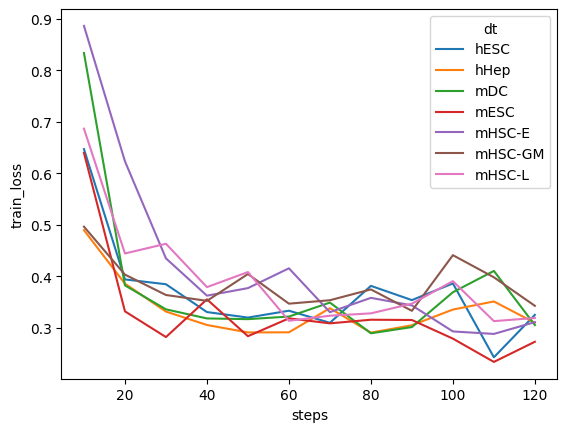

In [3]:
sns.lineplot(pd.concat(auprr_dts), x='steps', y='train_loss', hue='dt')

<Axes: xlabel='steps', ylabel='auprr'>

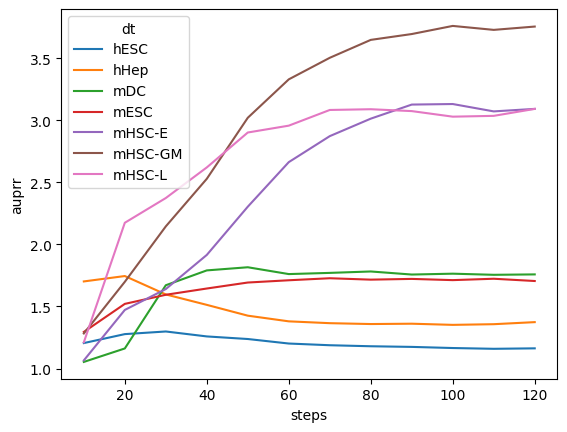

In [4]:
sns.lineplot(pd.concat(auprr_dts), x='steps', y='auprr', hue='dt')

In [8]:
def read_hammond(time):
    ann_dt = sc.read_csv(
        f'../grnvae/data/other_data/Hammond_processed/final/male_{time}_data.csv'
    )
    
    ann_dt = ann_dt.transpose()
    
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Gm')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('mt')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rpl')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rps')]
    
    sc.pp.filter_genes(ann_dt, min_counts=10)
    print(f'Hammond data at {time}: {ann_dt.shape}')
    
    return ann_dt

In [9]:
def read_cerebellum(selected_celltype):
    ann_dt = sc.read_h5ad(f'data/cerebellum/SCP795/processed/{selected_celltype}.h5ad')
    ann_dt = ann_dt.transpose()

    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Gm')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('mt')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rpl')]
    ann_dt = ann_dt[:, ~ann_dt.var_names.str.startswith('Rps')]
    
    subset_qc = sc.pp.calculate_qc_metrics(ann_dt)
    # Here we only take roughly half of the genes (12,000). So we set the total 
    # number of gene cutoff point at the median
    total_gene_cutoff = subset_qc[1].total_counts.median()
    
    sc.pp.filter_genes(ann_dt, min_counts=total_gene_cutoff + 1)
    sc.pp.log1p(ann_dt)

    return ann_dt

In [10]:
hammond_p100 = read_hammond('p100')

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Hammond data at p100: (8259, 11484)


In [ ]:
trainer = rd.RegDiffusionTrainer(hammond_p100.X)
trainer.train()

Training loss: nan:  53%|████████████████████████████████████████████████▊                                           | 531/1000 [01:14<01:05,  7.19it/s]

In [ ]:
trainer.training_curve()

In [111]:
grn = trainer.generate_grn(hammond_p100.var_names)

In [115]:
grn.extract_node_neighbors('Apoe', k=60)

,Source,Target,Weight
0,Lyz2,Apoe,0.000980
1,Apoe,Lyz2,0.000805
2,H2.Eb1,Apoe,0.000450
3,Lag3,Apoe,0.000448
4,Cd63,Apoe,0.000445
5,Mrc1,Apoe,0.000441
6,Cd74,Apoe,0.000407
7,Apoe,H2.Ab1,0.000407
8,Apoe,H2.Eb1,0.000387
9,B2m,Apoe,0.000383


In [108]:
adj_table = grn.extract_node_neighborhood('Apoe', k=30)
adj_table.weight = adj_table.weight.map(lambda x: [0, 0.5, 1, 2][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [84]:
cc = read_cerebellum('Microglia')

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [91]:
cc.X

<1296x10010 sparse matrix of type '<class 'numpy.float32'>'
	with 1600379 stored elements in Compressed Sparse Column format>

In [93]:
trainer = rd.RegDiffusionTrainer(cc.X.toarray(), lr_adj=2e-5)
trainer.train()
adj = trainer.get_adj()

Training loss: 0.207: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:48<00:00,  9.18it/s]


In [94]:
grn = trainer.generate_grn(cc.var_names)
adj_table = grn.extract_node_neighborhood('Apoe')
adj_table.weight = adj_table.weight.map(lambda x: [0, 0.5, 1, 3][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html
